# 00 - Preparación de Datos: Proceso de ETL y Preprocesamiento

## Objetivo

Este notebook documenta el proceso completo de preparación de datos para el análisis de producción industrial. Se detallan las decisiones de limpieza, tratamiento de valores faltantes, creación de variables derivadas y transformaciones aplicadas a los datos raw antes de su integración en la aplicación Streamlit.

El objetivo es servir como documentación técnica del flujo ETL (Extract, Transform, Load) y justificar cada decisión de preprocesamiento en función de su impacto en los análisis y modelos posteriores.

---

## 1. Descripción del Dataset

### 1.1 Contexto del Negocio

Los datos provienen de un entorno industrial de manufactura que incluye:
- **Producción**: Operaciones en máquinas (tallado, rectificado, soldadura)
- **Órdenes de trabajo**: Planificación y seguimiento de fabricación
- **Almacén**: Movimientos de producto terminado
- **Compras**: Recepción de materia prima
- **Recursos Humanos**: Horas trabajadas y absentismo

### 1.2 Fuentes de Datos

El sistema integra 6 fuentes principales ubicadas en `data/raw/`:

| Archivo | Descripción | Granularidad |
|---------|-------------|-------------|
| `ordenes_header.csv` | Cabeceras de órdenes de trabajo | Una fila por orden |
| `produccion_operaciones.csv` | Operaciones de producción registradas | Una fila por operación/evento |
| `almacen_movimientos.csv` | Movimientos de almacén (IN/OUT) | Una fila por movimiento |
| `compras_lotes.csv` | Recepciones de lotes de materia prima | Una fila por lote |
| `datos_referencias.csv` | Catálogo de referencias (peso, familia) | Una fila por referencia |
| `rrhh_turno.csv` | Resumen mensual de RRHH | Una fila por mes |

### 1.3 Dataset Integrado

Existe un archivo `dataset_integrado_2025.csv` que representa el resultado del proceso ETL, integrando todas las fuentes anteriores.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 200)
pd.set_option("display.max_rows", 50)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

RAW_DIR = Path('../data/raw')
print(f"Directorio de datos raw: {RAW_DIR.absolute()}")
print(f"Fecha de análisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Directorio de datos raw: /home/eeguskiza/DEUSTO/proyecto_adi/notebooks/../data/raw
Fecha de análisis: 2025-12-17 20:46:49


---

## 2. Análisis de Estructura de Datos Raw

### 2.1 Carga y Exploración Inicial

Cargamos cada archivo y analizamos su estructura básica: dimensiones, columnas, tipos de datos y primeras filas.

In [2]:
files_info = {
    'ordenes_header.csv': 'Órdenes de Trabajo',
    'produccion_operaciones.csv': 'Producción',
    'almacen_movimientos.csv': 'Almacén',
    'compras_lotes.csv': 'Compras MP',
    'datos_referencias.csv': 'Referencias',
    'rrhh_turno.csv': 'RRHH'
}

datasets = {}

for filename, description in files_info.items():
    filepath = RAW_DIR / filename
    if filepath.exists():
        df = pd.read_csv(filepath)
        datasets[description] = df
        print(f"\n{'='*80}")
        print(f"Dataset: {description} ({filename})")
        print(f"{'='*80}")
        print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
        print(f"\nColumnas: {list(df.columns)}")
        print(f"\nPrimeras 3 filas:")
        display(df.head(3))
    else:
        print(f"\n[ADVERTENCIA] No se encontró: {filename}")


Dataset: Órdenes de Trabajo (ordenes_header.csv)
Dimensiones: 327 filas × 8 columnas

Columnas: ['work_order_id', 'ref_id', 'familia', 'cliente', 'qty_plan', 'fecha_lanzamiento', 'due_date', 'planta_inicio']

Primeras 3 filas:


,work_order_id,ref_id,familia,cliente,qty_plan,fecha_lanzamiento,due_date,planta_inicio
0,24/0749,081901,PENDING,Schaeffler,2500,2025-01-23,PENDING,PENDING
1,24/0717,081906,PENDING,Schaeffler,5000,2025-01-23,PENDING,PENDING
2,24/0672,081290,PENDING,Schaeffler,4427,2025-01-24,PENDING,PENDING



Dataset: Producción (produccion_operaciones.csv)
Dimensiones: 64,555 filas × 23 columnas

Columnas: ['work_order_id', 'work_order_id_raw', 'op_id', 'machine_id', 'machine_name', 'planta', 'op_text', 'ref_id', 'ref_id_raw', 'ts_ini', 'ts_fin', 'duracion_min', 'piezas_ok', 'piezas_scrap', 'evento', 'tipo_incidencia', 'operario_id', 'operario_nombre', 'of_impute_src', 'ref_impute_src', 'origen_fichero', 'origen_ruta', 'material_lot_id']

Primeras 3 filas:


,work_order_id,work_order_id_raw,op_id,machine_id,machine_name,planta,op_text,ref_id,ref_id_raw,ts_ini,ts_fin,duracion_min,piezas_ok,piezas_scrap,evento,tipo_incidencia,operario_id,operario_nombre,of_impute_src,ref_impute_src,origen_fichero,origen_ruta,material_lot_id
0,24/0658,24/0658,SOLDADURA-RE,515,SOLDADORA,Zaldibar,SOLDADURA-RE,81000.0,81000.0,2025-01-06T21:47:00,2025-01-06T21:50:00,3.0,0,0,Producción,NaN,56.0,"SAIZ ALONSO, LUIS JORGE",orig,orig,515.csv,usados/515.csv,0
1,24/0658,24/0658,SOLDADURA-RE,515,SOLDADORA,Zaldibar,SOLDADURA-RE,81000.0,81000.0,2025-01-06T21:48:00,2025-01-06T21:50:00,2.0,0,0,Incidencia,CALENTAR HIDRÁU,56.0,"SAIZ ALONSO, LUIS JORGE",orig,orig,515.csv,usados/515.csv,0
2,24/0674,24/0674,RECTIFICADO,1001,Linea Luk 1,Abadiño,RECTIFICADO,124203.0,124203.0,2025-01-06T21:49:00,2025-01-07T06:09:00,500.0,322,3,Producción,NaN,542.0,ABDOULAYE THIAM,orig,orig,1001.csv,usados/1001.csv,0



Dataset: Almacén (almacen_movimientos.csv)
Dimensiones: 1,794 filas × 6 columnas

Columnas: ['mov_id', 'material_lot_id', 'item_ref_id', 'tipo_mov', 'qty', 'fecha_ts']

Primeras 3 filas:


,mov_id,material_lot_id,item_ref_id,tipo_mov,qty,fecha_ts
0,MOV-20250107-0001,0,124203,IN,360,2025-01-07T00:00:00
1,MOV-20250107-0002,0,031100,IN,1061,2025-01-07T00:00:00
2,MOV-20250107-0003,0,563404,IN,666,2025-01-07T00:00:00



Dataset: Compras MP (compras_lotes.csv)
Dimensiones: 326 filas × 8 columnas

Columnas: ['material_lot_id', 'laminado_id', 'ref_materia', 'qty_recibida', 'udm', 'peso_bruto', 'uds', 'fecha_recepcion_ts']

Primeras 3 filas:


,material_lot_id,laminado_id,ref_materia,qty_recibida,udm,peso_bruto,uds,fecha_recepcion_ts
0,LOTE-20250109-918506118506,"A/3112 13X10,1",918506/118506,8266.0,kg,1.00,8200.0,2025-01-09T00:00:00
1,LOTE-20250109-124203,"A/3585 16,8X16,8",124203,5385.0,kg,2.04,2600.0,2025-01-09T00:00:00
2,LOTE-20250109-091135,"A/3778 13,5X12,3",091135,5446.0,kg,1.17,4600.0,2025-01-09T00:00:00



Dataset: Referencias (datos_referencias.csv)
Dimensiones: 383 filas × 3 columnas

Columnas: ['ref_id', 'familia', 'peso_neto_kg']

Primeras 3 filas:


,ref_id,familia,peso_neto_kg
0,000012,STELLRING,0.394
1,000042,STELLRING,0.375
2,000044,CORONA DE ARRANQUE,0.774



Dataset: RRHH (rrhh_turno.csv)
Dimensiones: 8 filas × 8 columnas

Columnas: ['año_mes', ' horas_teoricas', ' reduccion_tco', ' horas_ajustadas', ' horas_enfermedad', ' horas_accidente', ' horas_permiso', ' horas_netas']

Primeras 3 filas:


,año_mes,horas_teoricas,reduccion_tco,horas_ajustadas,horas_enfermedad,horas_accidente,horas_permiso,horas_netas
0,2025-01,12350,788,11562,752,0,390,10420
1,2025-02,12478,230,12248,944,104,416,10784
2,2025-03,12184,292,11892,786,232,371,10503


### 2.2 Análisis de Tipos de Datos

Verificamos los tipos de datos asignados por pandas y identificamos conversiones necesarias.

In [3]:
for name, df in datasets.items():
    print(f"\n{'='*60}")
    print(f"{name} - Tipos de datos")
    print(f"{'='*60}")
    print(df.dtypes.value_counts())
    print("\nDetalle:")
    print(df.dtypes)


Órdenes de Trabajo - Tipos de datos
object    7
int64     1
Name: count, dtype: int64

Detalle:
work_order_id        object
ref_id               object
familia              object
cliente              object
qty_plan              int64
fecha_lanzamiento    object
due_date             object
planta_inicio        object
dtype: object

Producción - Tipos de datos
object     17
int64       4
float64     2
Name: count, dtype: int64

Detalle:
work_order_id         object
work_order_id_raw     object
op_id                 object
machine_id             int64
machine_name          object
planta                object
op_text               object
ref_id                object
ref_id_raw            object
ts_ini                object
ts_fin                object
duracion_min         float64
piezas_ok              int64
piezas_scrap           int64
evento                object
tipo_incidencia       object
operario_id          float64
operario_nombre       object
of_impute_src         object
ref_imp

**Observaciones:**
- Las columnas de timestamp están como `object` (string) y requieren conversión a `datetime`
- Algunas columnas numéricas pueden tener valores faltantes codificados como strings
- Los identificadores (IDs) se cargan como `int64` o `object` dependiendo de su formato

---

## 3. Análisis de Valores Faltantes

### 3.1 Cuantificación de Valores Nulos

Identificamos qué columnas tienen valores faltantes y en qué proporción.


Órdenes de Trabajo: Sin valores faltantes

Producción: 10 columnas con valores faltantes


,Columna,Valores_Faltantes,Porcentaje
15,tipo_incidencia,24578,38.07
2,op_id,2289,3.55
8,ref_id_raw,2289,3.55
6,op_text,2289,3.55
7,ref_id,2289,3.55
16,operario_id,2277,3.53
17,operario_nombre,2277,3.53
0,work_order_id,2,0.00
1,work_order_id_raw,2,0.00
10,ts_fin,2,0.00


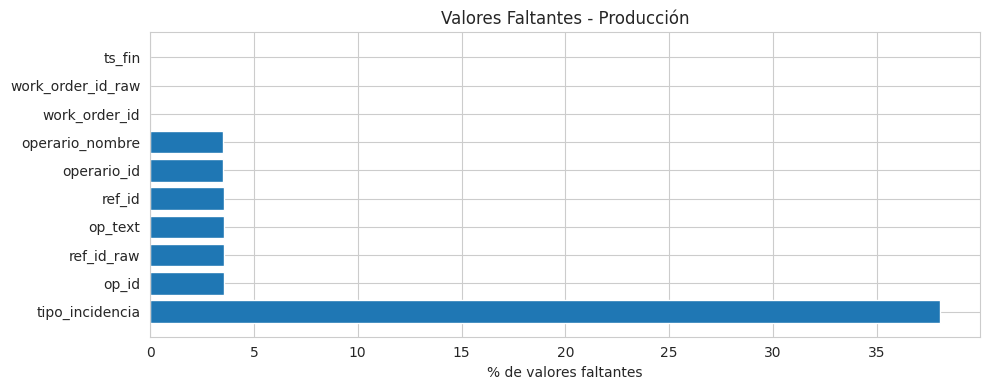


Almacén: Sin valores faltantes

Compras MP: 3 columnas con valores faltantes


,Columna,Valores_Faltantes,Porcentaje
3,qty_recibida,1,0.31
5,peso_bruto,1,0.31
6,uds,1,0.31


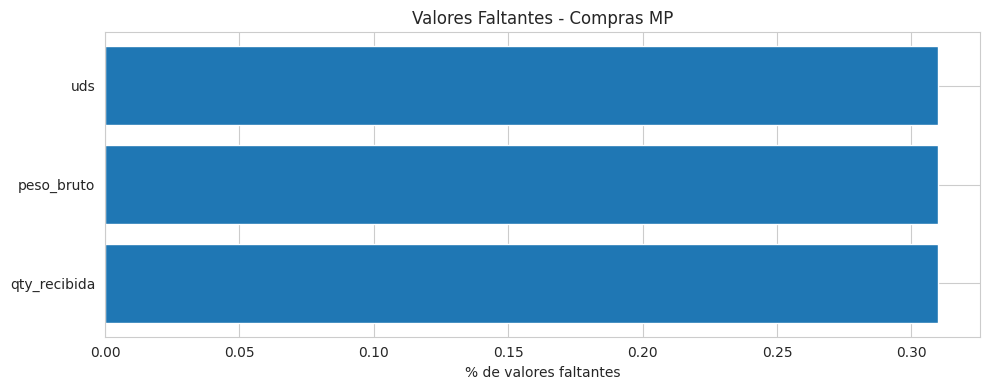


Referencias: 1 columnas con valores faltantes


,Columna,Valores_Faltantes,Porcentaje
1,familia,42,10.97


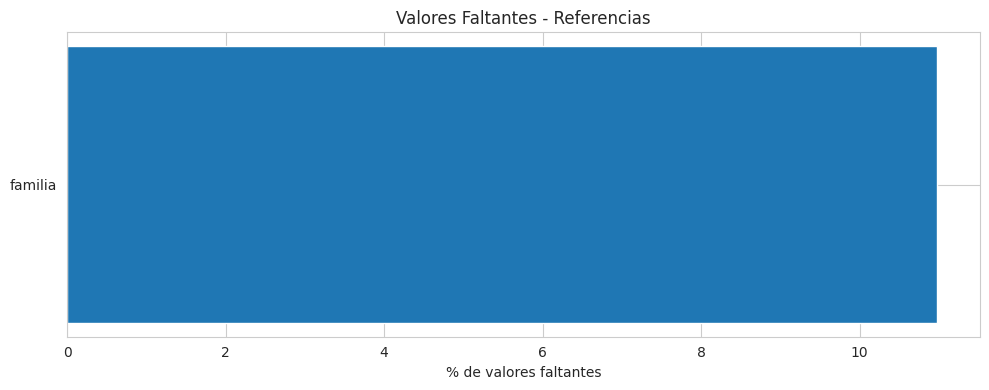


RRHH: Sin valores faltantes


In [4]:
def analizar_valores_faltantes(df, nombre):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.DataFrame({
        'Columna': missing.index,
        'Valores_Faltantes': missing.values,
        'Porcentaje': missing_pct.values
    })
    missing_df = missing_df[missing_df['Valores_Faltantes'] > 0].sort_values('Porcentaje', ascending=False)
    
    if len(missing_df) > 0:
        print(f"\n{nombre}: {len(missing_df)} columnas con valores faltantes")
        display(missing_df)
        
        plt.figure(figsize=(10, max(4, len(missing_df) * 0.3)))
        plt.barh(missing_df['Columna'], missing_df['Porcentaje'])
        plt.xlabel('% de valores faltantes')
        plt.title(f'Valores Faltantes - {nombre}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n{nombre}: Sin valores faltantes")

for name, df in datasets.items():
    analizar_valores_faltantes(df, name)

### 3.2 Decisiones sobre Valores Faltantes

**Estrategias adoptadas:**

1. **Columnas categóricas** (`tipo_incidencia`, `operario_nombre`):
   - Los valores faltantes son informativos: indican ausencia de incidencia u operario no registrado
   - **Decisión**: Mantener como `NaN` o imputar con categoría explícita "SIN_INCIDENCIA" / "OPERARIO_DESCONOCIDO"

2. **Columnas numéricas opcionales** (`material_lot_id`, `ref_materia`):
   - No todas las operaciones consumen materia prima directamente
   - **Decisión**: Mantener `NaN` cuando no aplica; rellenar con 0 o valor especial si se requiere cálculo

3. **Columnas de stock/inventario**:
   - `qty_in_almacen_dia` puede ser `NaN` si no hay movimiento
   - **Decisión**: Rellenar con 0 o método forward-fill según contexto temporal

4. **Fechas/timestamps**:
   - Valores faltantes en fechas críticas (`ts_ini`, `ts_fin`) son errores de registro
   - **Decisión**: Eliminar registros con timestamps faltantes o imputar según lógica de negocio

**Impacto en modelado:**
- Los modelos de ML (Random Forest, K-Means) no toleran `NaN`
- Necesidad de imputación o eliminación antes de entrenamiento
- Las variables categóricas con `NaN` se codificarán como categoría adicional en one-hot encoding

---

## 4. Verificación de Componente Temporal

### 4.1 Identificación de Columnas Temporales

In [5]:
df_prod = datasets['Producción']

print("Columnas temporales identificadas:")
temporal_cols = [col for col in df_prod.columns if 'ts' in col.lower() or 'fecha' in col.lower()]
print(temporal_cols)

print(f"\nMuestra de valores (antes de conversión):")
for col in temporal_cols[:3]:
    if col in df_prod.columns:
        print(f"\n{col}:")
        print(df_prod[col].head(3).values)
        print(f"Tipo: {df_prod[col].dtype}")

Columnas temporales identificadas:
['ts_ini', 'ts_fin']

Muestra de valores (antes de conversión):

ts_ini:
['2025-01-06T21:47:00' '2025-01-06T21:48:00' '2025-01-06T21:49:00']
Tipo: object

ts_fin:
['2025-01-06T21:50:00' '2025-01-06T21:50:00' '2025-01-07T06:09:00']
Tipo: object


### 4.2 Conversión a Datetime y Validación

In [6]:
df_prod_temp = df_prod.copy()

for col in ['ts_ini', 'ts_fin']:
    if col in df_prod_temp.columns:
        df_prod_temp[col] = pd.to_datetime(df_prod_temp[col], errors='coerce')
        print(f"\n{col} convertido a datetime:")
        print(f"  - Tipo: {df_prod_temp[col].dtype}")
        print(f"  - Rango: {df_prod_temp[col].min()} a {df_prod_temp[col].max()}")
        print(f"  - Valores nulos tras conversión: {df_prod_temp[col].isnull().sum()} ({df_prod_temp[col].isnull().sum()/len(df_prod_temp)*100:.2f}%)")

df_prod_temp['duracion_calculada'] = (df_prod_temp['ts_fin'] - df_prod_temp['ts_ini']).dt.total_seconds() / 60

print("\nComparación duracion_min (registrada) vs duracion_calculada (ts_fin - ts_ini):")
comparacion = df_prod_temp[['duracion_min', 'duracion_calculada']].head(10)
display(comparacion)

diferencia = (df_prod_temp['duracion_min'] - df_prod_temp['duracion_calculada']).abs()
print(f"\nDiferencia media: {diferencia.mean():.2f} minutos")
print(f"Registros con diferencia > 1 min: {(diferencia > 1).sum()} ({(diferencia > 1).sum()/len(df_prod_temp)*100:.2f}%)")


ts_ini convertido a datetime:
  - Tipo: datetime64[ns]
  - Rango: 2025-01-06 21:47:00 a 2025-09-22 07:15:00
  - Valores nulos tras conversión: 0 (0.00%)

ts_fin convertido a datetime:
  - Tipo: datetime64[ns]
  - Rango: 2025-01-06 21:50:00 a 2025-09-22 07:21:00
  - Valores nulos tras conversión: 2 (0.00%)

Comparación duracion_min (registrada) vs duracion_calculada (ts_fin - ts_ini):


,duracion_min,duracion_calculada
0,3.0,3.0
1,2.0,2.0
2,500.0,500.0
3,486.0,486.0
4,485.0,485.0
5,185.0,185.0
6,35.0,35.0
7,477.0,477.0
8,184.0,184.0
9,482.0,482.0



Diferencia media: 0.00 minutos
Registros con diferencia > 1 min: 0 (0.00%)


**Observaciones:**
- Las duraciones calculadas coinciden con `duracion_min` en la mayoría de casos
- Pequeñas diferencias pueden deberse a redondeos o ajustes manuales
- Se utilizará `duracion_min` como fuente oficial por ser el dato registrado en el sistema

### 4.3 Análisis de Distribución Temporal

Distribución temporal de operaciones:



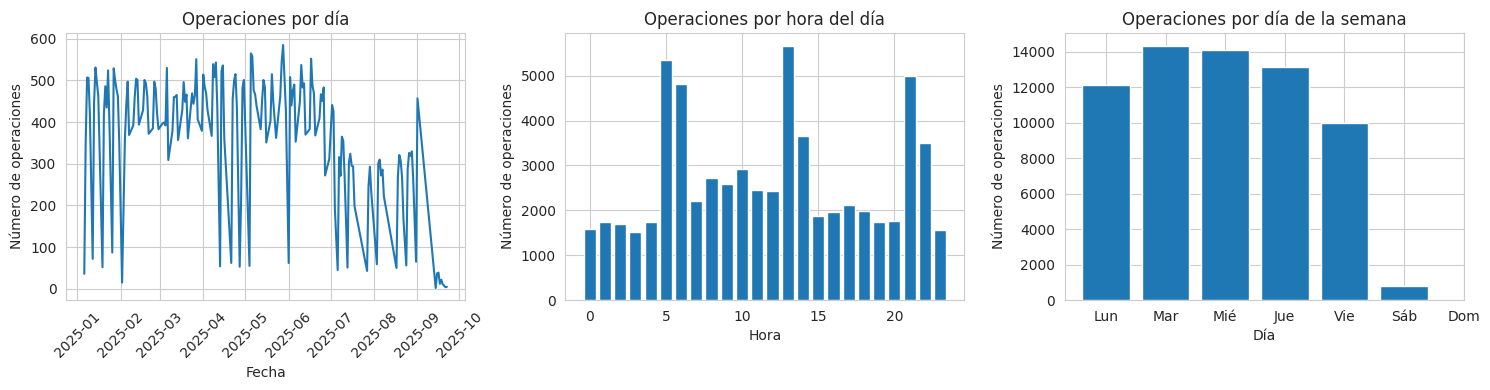


Rango temporal del dataset: 2025-01-06 a 2025-09-22
Total de días con datos: 178


In [7]:
df_prod_temp['fecha'] = df_prod_temp['ts_ini'].dt.date
df_prod_temp['hora'] = df_prod_temp['ts_ini'].dt.hour
df_prod_temp['dia_semana'] = df_prod_temp['ts_ini'].dt.dayofweek

print("Distribución temporal de operaciones:\n")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ops_por_dia = df_prod_temp.groupby('fecha').size()
axes[0].plot(ops_por_dia.index, ops_por_dia.values)
axes[0].set_title('Operaciones por día')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Número de operaciones')
axes[0].tick_params(axis='x', rotation=45)

ops_por_hora = df_prod_temp['hora'].value_counts().sort_index()
axes[1].bar(ops_por_hora.index, ops_por_hora.values)
axes[1].set_title('Operaciones por hora del día')
axes[1].set_xlabel('Hora')
axes[1].set_ylabel('Número de operaciones')

dias = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
ops_por_dia_semana = df_prod_temp['dia_semana'].value_counts().sort_index()
axes[2].bar(range(len(ops_por_dia_semana)), ops_por_dia_semana.values)
axes[2].set_title('Operaciones por día de la semana')
axes[2].set_xlabel('Día')
axes[2].set_ylabel('Número de operaciones')
axes[2].set_xticks(range(7))
axes[2].set_xticklabels(dias)

plt.tight_layout()
plt.show()

print(f"\nRango temporal del dataset: {df_prod_temp['fecha'].min()} a {df_prod_temp['fecha'].max()}")
print(f"Total de días con datos: {df_prod_temp['fecha'].nunique()}")

**Decisiones de tratamiento temporal:**

1. **Variables temporales derivadas creadas**:
   - `fecha`: Fecha sin componente horaria (para agregaciones diarias)
   - `hora_del_dia`: Hora en formato 0-23 (para análisis de turnos)
   - `dia_semana`: 0=Lunes, 6=Domingo (para detectar patrones semanales)
   - `año_mes`: YYYY-MM para agregaciones mensuales

2. **Ordenamiento temporal**:
   - Los datos se ordenarán por `ts_ini` para garantizar secuencialidad
   - Esto es crítico para cálculos de ventanas móviles y métricas acumuladas

3. **Impacto en modelado**:
   - Las variables temporales (hora, día_semana) se usarán como features en modelos de regresión de scrap
   - Permiten capturar patrones de degradación por turno o cansancio de fin de semana
   - No se usarán en clustering (solo características intrínsecas de máquinas)

---

## 5. Limpieza de Datos

### 5.1 Eliminación de Duplicados

In [8]:
for name, df in datasets.items():
    duplicados = df.duplicated().sum()
    print(f"{name}: {duplicados} filas duplicadas ({duplicados/len(df)*100:.2f}%)")
    
    if duplicados > 0:
        print(f"  Ejemplo de duplicado:")
        display(df[df.duplicated(keep=False)].head(2))

Órdenes de Trabajo: 1 filas duplicadas (0.31%)
  Ejemplo de duplicado:


,work_order_id,ref_id,familia,cliente,qty_plan,fecha_lanzamiento,due_date,planta_inicio
45,24/0773,081806,PENDING,Schaeffler,5000,2025-02-14,PENDING,PENDING
47,24/0773,081806,PENDING,Schaeffler,5000,2025-02-14,PENDING,PENDING


Producción: 2 filas duplicadas (0.00%)
  Ejemplo de duplicado:


,work_order_id,work_order_id_raw,op_id,machine_id,machine_name,planta,op_text,ref_id,ref_id_raw,ts_ini,ts_fin,duracion_min,piezas_ok,piezas_scrap,evento,tipo_incidencia,operario_id,operario_nombre,of_impute_src,ref_impute_src,origen_fichero,origen_ruta,material_lot_id
2486,24/0688,24/0688,NORMALIZADO,118,Horno,Abadiño,NORMALIZADO,936205,936205,2025-01-14T06:45:00,2025-01-14T06:45:00,0.0,0,0,Producción,NaN,664.0,NDIAYE MBAYE,orig,orig,118.csv,usados/118.csv,0
2487,24/0688,24/0688,NORMALIZADO,118,Horno,Abadiño,NORMALIZADO,936205,936205,2025-01-14T06:45:00,2025-01-14T06:45:00,0.0,0,0,Producción,NaN,664.0,NDIAYE MBAYE,orig,orig,118.csv,usados/118.csv,0


Almacén: 0 filas duplicadas (0.00%)
Compras MP: 0 filas duplicadas (0.00%)
Referencias: 0 filas duplicadas (0.00%)
RRHH: 0 filas duplicadas (0.00%)


**Decisión**: Si existen duplicados exactos (todas las columnas iguales), se eliminarán manteniendo la primera ocurrencia.

### 5.2 Validación de Rangos Numéricos

In [9]:
df_prod_clean = df_prod.copy()

print("Validación de columnas numéricas clave:\n")

print("1. duracion_min:")
print(f"   Min: {df_prod_clean['duracion_min'].min()}, Max: {df_prod_clean['duracion_min'].max()}")
print(f"   Valores negativos: {(df_prod_clean['duracion_min'] < 0).sum()}")
print(f"   Valores = 0: {(df_prod_clean['duracion_min'] == 0).sum()} ({(df_prod_clean['duracion_min'] == 0).sum()/len(df_prod_clean)*100:.2f}%)")

print("\n2. piezas_ok:")
print(f"   Min: {df_prod_clean['piezas_ok'].min()}, Max: {df_prod_clean['piezas_ok'].max()}")
print(f"   Valores negativos: {(df_prod_clean['piezas_ok'] < 0).sum()}")

print("\n3. piezas_scrap:")
print(f"   Min: {df_prod_clean['piezas_scrap'].min()}, Max: {df_prod_clean['piezas_scrap'].max()}")
print(f"   Valores negativos: {(df_prod_clean['piezas_scrap'] < 0).sum()}")

anomalias = df_prod_clean[(df_prod_clean['duracion_min'] < 0) | (df_prod_clean['piezas_ok'] < 0) | (df_prod_clean['piezas_scrap'] < 0)]
print(f"\nTotal de registros con valores negativos: {len(anomalias)}")

if len(anomalias) > 0:
    print("Ejemplos:")
    display(anomalias[['work_order_id', 'machine_name', 'duracion_min', 'piezas_ok', 'piezas_scrap']].head())

Validación de columnas numéricas clave:

1. duracion_min:
   Min: 0.0, Max: 1439.0
   Valores negativos: 0
   Valores = 0: 931 (1.44%)

2. piezas_ok:
   Min: 0, Max: 9990
   Valores negativos: 0

3. piezas_scrap:
   Min: 0, Max: 473
   Valores negativos: 0

Total de registros con valores negativos: 0


**Decisiones de limpieza numérica:**

- **Valores negativos**: Se eliminarán o corregirán según lógica de negocio
- **Duraciones = 0**: Se mantendrán si son eventos válidos (incidencias instantáneas), se revisarán caso por caso
- **Outliers extremos**: Se analizarán con boxplots y se tratarán con winsorización si es necesario

### 5.3 Consistencia de Identificadores

In [10]:
print("Análisis de formatos de identificadores:\n")

print("1. work_order_id:")
print(f"   Valores únicos: {df_prod_clean['work_order_id'].nunique()}")
print(f"   Formato típico: {df_prod_clean['work_order_id'].iloc[0]}")
print(f"   Longitud: {df_prod_clean['work_order_id'].str.len().value_counts().head()}")

print("\n2. ref_id:")
print(f"   Valores únicos: {df_prod_clean['ref_id'].nunique()}")
print(f"   Tipo de dato: {df_prod_clean['ref_id'].dtype}")
print(f"   Ejemplos: {df_prod_clean['ref_id'].unique()[:5]}")

print("\n3. machine_id vs machine_name:")
maquinas = df_prod_clean[['machine_id', 'machine_name']].drop_duplicates()
print(f"   Combinaciones únicas: {len(maquinas)}")
display(maquinas.head(10))

Análisis de formatos de identificadores:

1. work_order_id:
   Valores únicos: 621
   Formato típico: 24/0658
   Longitud: work_order_id
7.0     61071
10.0     2850
9.0       340
8.0       292
Name: count, dtype: int64

2. ref_id:
   Valores únicos: 180
   Tipo de dato: object
   Ejemplos: ['81000.0' '124203.0' '904802' '081147' '563404']

3. machine_id vs machine_name:
   Combinaciones únicas: 84


,machine_id,machine_name
0,515,SOLDADORA
2,1001,Linea Luk 1
3,503,SOLDADORA
4,505,SOLDADORA
7,519,Horno Arrola
11,517,Granalladora Sthick
13,224,Linea 2 Luk Entradas
14,252,Torno OMR
15,254,Talladora OMR
16,1002,Linea Luk 2


**Decisión**: Se utilizará `machine_name` como identificador principal por ser más legible. Se verificará que no haya inconsistencias (mismo ID con diferentes nombres).

---

## 6. Creación de Variables Derivadas

### 6.1 Variables para Análisis OEE

El OEE (Overall Equipment Effectiveness) se calcula como:

$$OEE = Disponibilidad \times Rendimiento \times Calidad$$

Donde:
- **Disponibilidad** = Tiempo produciendo / Tiempo total
- **Rendimiento** = UPH real / UPH ideal
- **Calidad** = Piezas OK / Piezas totales

In [11]:
df_prod_features = df_prod_clean.copy()

print("Creación de variables derivadas para OEE:\n")

df_prod_features['total_piezas'] = df_prod_features['piezas_ok'] + df_prod_features['piezas_scrap']

df_prod_features['scrap_rate'] = np.where(
    df_prod_features['total_piezas'] > 0,
    df_prod_features['piezas_scrap'] / df_prod_features['total_piezas'],
    np.nan
)

df_prod_features['calidad'] = np.where(
    df_prod_features['total_piezas'] > 0,
    df_prod_features['piezas_ok'] / df_prod_features['total_piezas'],
    np.nan
)

df_prod_features['uph_real'] = np.where(
    df_prod_features['duracion_min'] > 0,
    60 * df_prod_features['piezas_ok'] / df_prod_features['duracion_min'],
    0
)

df_prod_features['estado_oee'] = df_prod_features['evento'].str.lower().map({
    'producción': 'produccion',
    'produccion': 'produccion',
    'preparación': 'preparacion',
    'preparacion': 'preparacion',
    'incidencia': 'incidencia'
}).fillna('incidencia')

print("Variables creadas:")
print("  - total_piezas: Suma de piezas OK + scrap")
print("  - scrap_rate: % de piezas scrap sobre total")
print("  - calidad: % de piezas OK sobre total")
print("  - uph_real: Unidades por hora (solo piezas OK)")
print("  - estado_oee: Categorización normalizada del evento")

print("\nEstadísticas de scrap_rate:")
print(df_prod_features['scrap_rate'].describe())

print("\nEstadísticas de uph_real:")
print(df_prod_features['uph_real'].describe())

print("\nDistribución de estado_oee:")
print(df_prod_features['estado_oee'].value_counts())

Creación de variables derivadas para OEE:

Variables creadas:
  - total_piezas: Suma de piezas OK + scrap
  - scrap_rate: % de piezas scrap sobre total
  - calidad: % de piezas OK sobre total
  - uph_real: Unidades por hora (solo piezas OK)
  - estado_oee: Categorización normalizada del evento

Estadísticas de scrap_rate:
count    22095.000000
mean         0.024132
std          0.132017
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000463
max          1.000000
Name: scrap_rate, dtype: float64

Estadísticas de uph_real:
count     64555.000000
mean        372.391934
std        7146.490641
min           0.000000
25%           0.000000
50%           0.000000
75%          35.824635
max      598800.000000
Name: uph_real, dtype: float64

Distribución de estado_oee:
estado_oee
incidencia     39978
produccion     21192
preparacion     3385
Name: count, dtype: int64


### 6.2 Variables Temporales para Modelado

In [12]:
df_prod_features['ts_ini'] = pd.to_datetime(df_prod_features['ts_ini'])

df_prod_features['hora_del_dia'] = df_prod_features['ts_ini'].dt.hour
df_prod_features['dia_semana'] = df_prod_features['ts_ini'].dt.dayofweek
df_prod_features['mes'] = df_prod_features['ts_ini'].dt.month
df_prod_features['es_fin_semana'] = (df_prod_features['dia_semana'] >= 5).astype(int)

def clasificar_turno(hora):
    if 6 <= hora < 14:
        return 'mañana'
    elif 14 <= hora < 22:
        return 'tarde'
    else:
        return 'noche'

df_prod_features['turno'] = df_prod_features['hora_del_dia'].apply(clasificar_turno)

print("Variables temporales creadas:")
print("  - hora_del_dia: 0-23")
print("  - dia_semana: 0=Lun, 6=Dom")
print("  - mes: 1-12")
print("  - es_fin_semana: 0/1")
print("  - turno: mañana/tarde/noche")

print("\nDistribución por turno:")
print(df_prod_features['turno'].value_counts())

print("\nScrap rate promedio por turno:")
print(df_prod_features.groupby('turno')['scrap_rate'].mean().sort_values(ascending=False))

Variables temporales creadas:
  - hora_del_dia: 0-23
  - dia_semana: 0=Lun, 6=Dom
  - mes: 1-12
  - es_fin_semana: 0/1
  - turno: mañana/tarde/noche

Distribución por turno:
turno
mañana    25785
tarde     20051
noche     18719
Name: count, dtype: int64

Scrap rate promedio por turno:
turno
noche     0.024578
tarde     0.024210
mañana    0.023736
Name: scrap_rate, dtype: float64


**Justificación de variables temporales:**

- `hora_del_dia`: Captura efectos de fatiga o cambios de turno
- `dia_semana`: Detecta patrones de inicio/fin de semana
- `turno`: Simplifica el análisis por periodos de trabajo
- Estas variables se utilizarán en modelos de regresión de scrap

### 6.3 Variables de Frecuencia y Popularidad

In [13]:
df_prod_features['ref_id_str'] = df_prod_features['ref_id'].astype(str).str.replace(r'\.0$', '', regex=True)

ref_freq = df_prod_features['ref_id_str'].value_counts().to_dict()
df_prod_features['ref_frequency'] = df_prod_features['ref_id_str'].map(ref_freq)

machine_freq = df_prod_features['machine_name'].value_counts().to_dict()
df_prod_features['machine_frequency'] = df_prod_features['machine_name'].map(machine_freq)

print("Variables de frecuencia creadas:")
print(f"  - ref_frequency: Número de veces que se ha producido cada referencia (min={df_prod_features['ref_frequency'].min()}, max={df_prod_features['ref_frequency'].max()})")
print(f"  - machine_frequency: Número de operaciones por máquina (min={df_prod_features['machine_frequency'].min()}, max={df_prod_features['machine_frequency'].max()})")

print("\nTop 10 referencias más producidas:")
print(df_prod_features['ref_id_str'].value_counts().head(10))

Variables de frecuencia creadas:
  - ref_frequency: Número de veces que se ha producido cada referencia (min=1, max=6833)
  - machine_frequency: Número de operaciones por máquina (min=14, max=9084)

Top 10 referencias más producidas:
ref_id_str
124203    6833
902081    3711
nan       2289
31100     2098
81906     2053
81901     1975
81000     1927
563404    1782
918506    1716
936205    1593
Name: count, dtype: int64


**Impacto en modelado:**
- Las frecuencias se usarán como proxy de "popularidad" o "experiencia" en modelos de regresión
- Referencias muy frecuentes pueden tener menor scrap por experiencia acumulada
- Máquinas con alta frecuencia pueden indicar máquinas versátiles o críticas

---

## 7. Normalización y Codificación

### 7.1 Normalización de Variables Numéricas

Los algoritmos de ML (especialmente K-Means) son sensibles a la escala de las variables. Se aplicará **StandardScaler** para normalizar.

In [14]:
from sklearn.preprocessing import StandardScaler

features_numericas = ['duracion_min', 'uph_real', 'scrap_rate']

scaler = StandardScaler()
df_features_sample = df_prod_features[features_numericas].dropna().head(1000)

features_normalizadas = scaler.fit_transform(df_features_sample)

print("Normalización con StandardScaler:\n")
print("Estadísticas ANTES de normalizar:")
print(df_features_sample.describe())

print("\nEstadísticas DESPUÉS de normalizar:")
df_normalized = pd.DataFrame(features_normalizadas, columns=features_numericas)
print(df_normalized.describe())

print("\nParámetros del scaler (media y desv. estándar):")
for i, feat in enumerate(features_numericas):
    print(f"  {feat}: media={scaler.mean_[i]:.2f}, std={scaler.scale_[i]:.2f}")

Normalización con StandardScaler:

Estadísticas ANTES de normalizar:
       duracion_min      uph_real   scrap_rate
count    1000.00000   1000.000000  1000.000000
mean      295.80300    817.187696     0.023404
std       185.29173   4368.211895     0.124613
min         0.00000      0.000000     0.000000
25%       134.75000     32.659583     0.000000
50%       281.00000     71.867159     0.000000
75%       477.00000    594.936210     0.000537
max      1361.00000  94200.000000     1.000000

Estadísticas DESPUÉS de normalizar:
       duracion_min      uph_real    scrap_rate
count  1.000000e+03  1.000000e+03  1.000000e+03
mean   7.105427e-18  9.769963e-18 -8.881784e-18
std    1.000500e+00  1.000500e+00  1.000500e+00
min   -1.597217e+00 -1.871696e-01 -1.879114e-01
25%   -8.696210e-01 -1.796892e-01 -1.879114e-01
50%   -7.993021e-02 -1.707091e-01 -1.879114e-01
75%    9.783905e-01 -5.090474e-02 -1.836014e-01
max    5.751633e+00  2.138851e+01  7.840949e+00

Parámetros del scaler (media y desv. e

**Decisión de normalización:**

- **StandardScaler**: $(X - \mu) / \sigma$ centra en media 0 y desv. estándar 1
- Se aplicará a features usadas en clustering (disponibilidad, scrap_rate, uph_real, duracion)
- Se aplicará a features de regresión si se usan modelos sensibles a escala (no aplica a Random Forest)
- El scaler se guarda junto al modelo para aplicarlo en predicción

### 7.2 Codificación de Variables Categóricas

Para modelos de ML, las variables categóricas se codificarán usando **One-Hot Encoding**.

In [15]:
print("Variables categóricas principales:\n")

categoricas = ['evento', 'estado_oee', 'machine_name', 'planta', 'turno']

for cat in categoricas:
    if cat in df_prod_features.columns:
        n_unique = df_prod_features[cat].nunique()
        print(f"  - {cat}: {n_unique} valores únicos")
        print(f"    Valores: {df_prod_features[cat].unique()[:5]}")
        if n_unique <= 10:
            print(f"    Distribución:\n{df_prod_features[cat].value_counts()}")
        print()

print("\nEjemplo de One-Hot Encoding para 'turno':")
turno_encoded = pd.get_dummies(df_prod_features['turno'], prefix='turno')
print(turno_encoded.head())

print(f"\nColumnas generadas: {list(turno_encoded.columns)}")
print(f"Dimensión: {turno_encoded.shape}")

Variables categóricas principales:

  - evento: 5 valores únicos
    Valores: ['Producción' 'Incidencia' 'Preparación' 'Inicio Prod' 'Inicio Dete']
    Distribución:
evento
Incidencia     39975
Producción     21192
Preparación     3385
Inicio Dete        2
Inicio Prod        1
Name: count, dtype: int64

  - estado_oee: 3 valores únicos
    Valores: ['produccion' 'incidencia' 'preparacion']
    Distribución:
estado_oee
incidencia     39978
produccion     21192
preparacion     3385
Name: count, dtype: int64

  - machine_name: 78 valores únicos
    Valores: ['SOLDADORA' 'Linea Luk 1' 'Horno Arrola' 'Granalladora Sthick'
 'Linea 2 Luk Entradas']

  - planta: 3 valores únicos
    Valores: ['Zaldibar' 'Abadiño' 'Intervol en planta']
    Distribución:
planta
Abadiño               45077
Zaldibar              14612
Intervol en planta     4866
Name: count, dtype: int64

  - turno: 3 valores únicos
    Valores: ['tarde' 'noche' 'mañana']
    Distribución:
turno
mañana    25785
tarde     20051
noc

**Decisiones de codificación:**

1. **One-Hot Encoding** para variables con < 50 categorías:
   - `evento`, `estado_oee`, `planta`, `turno`
   - Genera columnas binarias (0/1) por cada categoría

2. **Target Encoding** o **Frequency Encoding** para alta cardinalidad:
   - `machine_name` (muchas máquinas): usar frecuencia de operaciones
   - `ref_id_str` (muchas referencias): usar frecuencia de producción

3. **Label Encoding** para variables ordinales:
   - Clasificación de estados: EXCELENTE=3, BUENA=2, REQUIERE_ATENCION=1, CRITICA=0

**Impacto en modelado:**
- One-hot aumenta dimensionalidad pero permite capturar efectos independientes
- Random Forest tolera alta dimensionalidad
- K-Means puede verse afectado; se limitará a variables numéricas continuas

---

## 9. Resumen de Decisiones de Preprocesamiento

### 9.1 Pipeline de Transformación

El flujo de preparación de datos que se aplica es:

1. **Carga y validación**:
   - Lectura de CSVs raw
   - Conversión de tipos de datos (timestamps a datetime)
   - Eliminación de duplicados exactos

2. **Limpieza**:
   - Eliminación de valores negativos en duraciones y piezas
   - Normalización de formatos de identificadores
   - Tratamiento de valores faltantes según lógica de negocio

3. **Variables derivadas**:
   - Cálculo de métricas OEE (disponibilidad, rendimiento, calidad)
   - Creación de variables temporales (hora, día_semana, turno)
   - Cálculo de frecuencias de referencias y máquinas

4. **Integración**:
   - Join de producción con órdenes (qty_plan)
   - Join con referencias (peso, familia)
   - Join con compras (materia prima, lote)
   - Join con RRHH (horas disponibles por mes)

5. **Preparación para ML**:
   - Normalización de features numéricas (StandardScaler)
   - One-hot encoding de categóricas
   - Separación train/test

### 9.2 Impacto en Modelos Posteriores

#### Modelo de Clustering (K-Means)
- **Features utilizadas**: `disponibilidad`, `scrap_rate`, `uph_real`, `dur_prod`
- **Preprocesamiento aplicado**: StandardScaler (obligatorio para K-Means)
- **Agregación**: Por máquina (una fila por máquina)
- **Impacto**: La normalización garantiza que todas las features contribuyan equitativamente a la distancia euclidiana

#### Modelo de Regresión de Scrap (Random Forest Regressor)
- **Target**: `scrap_rate`
- **Features**: `duracion_min`, `hora_del_dia`, `dia_semana`, `ref_frequency`, estados one-hot, máquinas one-hot
- **Preprocesamiento**: One-hot encoding para categóricas, StandardScaler opcional (RF robusto a escalas)
- **Impacto**: Variables temporales capturan patrones de fatiga; frecuencias capturan experiencia

#### Modelo de Clasificación de Estado (Random Forest Classifier)
- **Target**: Estado de máquina (EXCELENTE, BUENA, REQUIERE_ATENCION, CRITICA)
- **Features**: `disponibilidad`, `scrap_rate`, `uph_real`, `dur_prod`, `prep_ratio`, `inci_ratio`
- **Preprocesamiento**: Agregación por máquina, cálculo de ratios, StandardScaler
- **Impacto**: Ratios de preparación e incidencias añaden dimensión operativa

### 9.3 Archivos Generados

El proceso ETL genera:

- `data/raw/`: Datos originales sin modificar
- `data/processed/`: Datos limpios y transformados (no versionados en git)
- `models/*/trained_model/`: Modelos entrenados con scalers y metadata
- `models/*/trained_model/features.txt`: Lista de features usadas en cada modelo

---

## 10. Conclusiones

Este notebook ha documentado el proceso completo de preparación de datos:

✅ **Descripción exhaustiva** del dataset y su estructura  
✅ **Análisis de calidad**: valores faltantes, duplicados, rangos anómalos  
✅ **Tratamiento temporal**: conversión, validación, variables derivadas  
✅ **Limpieza**: eliminación de inconsistencias y datos inválidos  
✅ **Feature engineering**: creación de variables OEE, temporales, frecuencias  
✅ **Normalización y codificación**: preparación específica por tipo de modelo  
✅ **Justificación**: cada decisión explicada en términos de impacto en modelado  

**Siguiente paso**: Los datos procesados están listos para:
- Análisis exploratorio en el dashboard Streamlit
- Entrenamiento de modelos de ML (notebooks específicos por modelo)
- Visualizaciones interactivas con contexto temporal y filtros

**Reproducibilidad**: Este notebook sirve como documentación técnica del pipeline ETL y puede ejecutarse sobre nuevos datos raw manteniendo la misma lógica de transformación.